# Customer Churn Prediction
Predict when a customer of an insurance company is likely to cancel their insurance product.

Data Source: https://www.kaggle.com/mukulsingh/insurance-churn-prediction

Libraries:

In [1]:
library(psych)
library(ggplot2)
#library(GGally) 
library(ggplot2)
#library(reshape2)
#library(corrgram)
#library(corrplot)
library(OneR)


Attaching package: 'ggplot2'


The following objects are masked from 'package:psych':

    %+%, alpha


Warning message:
"package 'OneR' was built under R version 3.6.3"


Read in the test and train datasets

In [2]:
test <- read.csv(file = 'testSet.csv')
train <-  read.csv(file = 'trainSet.csv')

Our approach:

What are we doing? What is the goal? How will we predict churn?
1. Explore individual variables, their characteristics such as spread, variance, distribution etc.
2. Identify important features which have a relationship with our label, and how they interact.
3. Explore the qualities of the relationships to identify which models will give strongest results, and how we can transform the data to aid with learning.
4. Identify features with no relationship and exclude them from our models, for improved efficiency and reduced over fitting.
5. Identify features which strongly correlate with one another, to eliminate duplicate information. 
6. Build effective models which are supported by our exploration.

# Exploratory Data Analysis

First look at the data

In [ ]:
head(train)

Check the data types.

In [ ]:
str(train)

We want to be certain that the two test and train datasets are compatible with one another. Do they have the same data types? The same features in each?

In [ ]:
 str(test)

We are satisfied that features 0-6 are numeric type and 7-15 are integer in both test and train sets. It's possible that some of these integer variables are categoric / non-ordinal / qualitative and that there is no order to their numeric assignment. One hot encoding might need to be concidered later, we really don't know enough about the data for now though.

What proportion of the data is test versus train?

In [ ]:
dim(test)[1] / (dim(test)[1] + dim(train)[1])

One fifth of our total data is in the test dataset

## Single Variable Exploration

How is the response variable distributed? Is it imbalanced? Is it biased?

In [ ]:
barplot(table(train$labels), xlab = "Labels", main = "Class distribution of Labels")

There is no **detectable** bias in the label data, as we do not know any true information about real churn rates compared to the rates observed in this dataset. However, the class distribution in the label is very imbalanced (regardless of bias), this will likely become an issue for many learning algorithms later.



Descriptive statistics for continuous data:

Descriptive statistics for qualitative data: ??

More detailed summary statistics

In [ ]:
round(describe(train), 3)

Some initital findings from summary statistics:
- No missing data in any features
- Not yet feature scaled (e.g. min-max scaling), might need to do this for some models
- Feature 1 , 6 and 10 have highest skew, in the positive direction. Negative skewed variables are minimally affected.
- Features 1 & 6 have the widest range
- Features 10, 11 and 12 are integer and have a range of 1, making them binomial (as well as label)
- Features 1, 4, 6 and 10 have relatively high kurtosis, making their tails very short. Conversely, quite a few variables have longer tails, measuring no lesser than -2 though
- Given that we don't have any particular knowledge about each feature, we cannot comment on the expected or unexpected characteristics of each variable.
- 7 & 14 have highest standard deviation

Histograms for our continuous data:

# Density plots would be better here!?

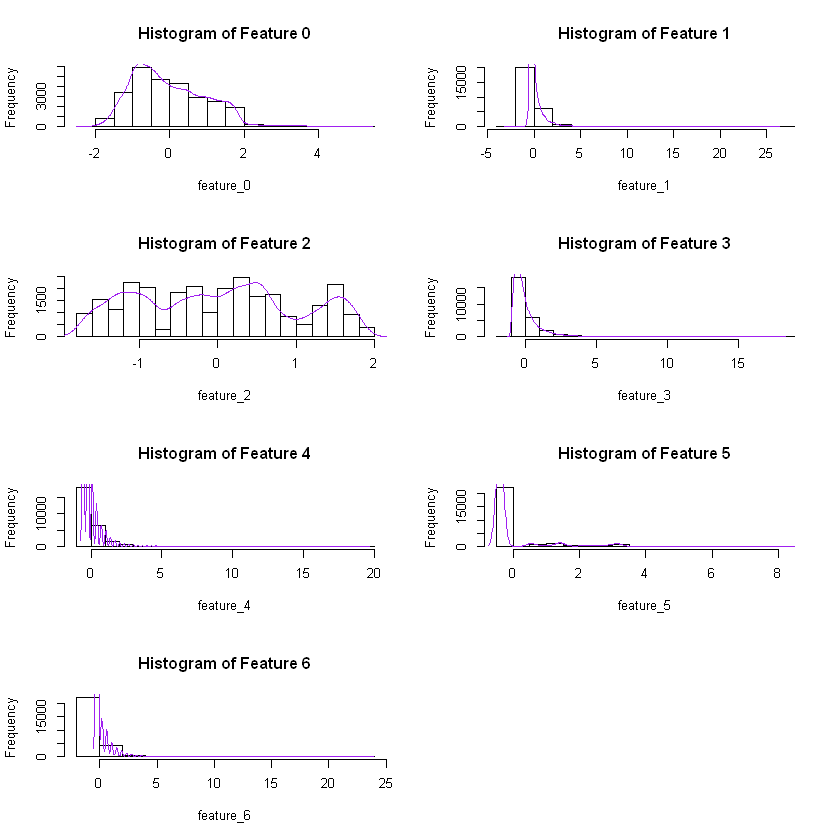

In [18]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=1) 

# Histogram for features 0 to 6
par(mfrow = c(4,2))
for (i in 1:7 ) {
    h <- hist(train[,i], plot=FALSE)
    plot(h, main=paste("Histogram of Feature", i-1), xlab = names(train[i]))
    d <- density(train[,i])
    lines(x = d$x, y = d$y * length(train[,i]) * diff(h$breaks)[1], col = "purple", lwd = 1)
}

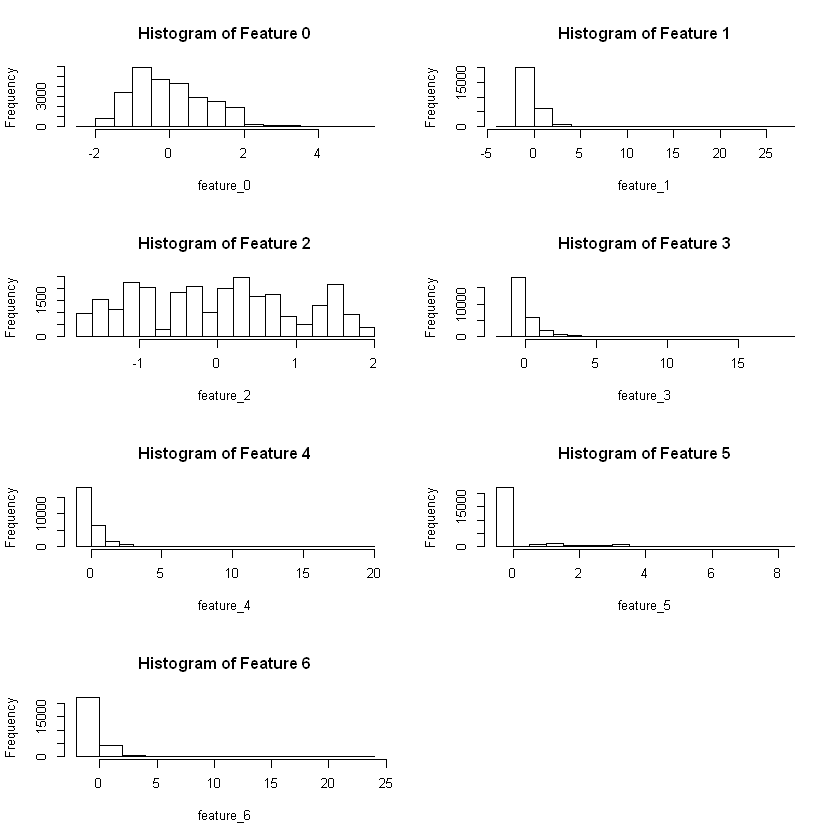

In [19]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=1) 

# Histogram for features 0 to 6
par(mfrow = c(4,2))
for (i in 1:7 ) {
        hist(train[,i], xlab = names(train[i]), main = paste("Histogram of Feature", i-1))
}

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""add" is not a graphical parameter"


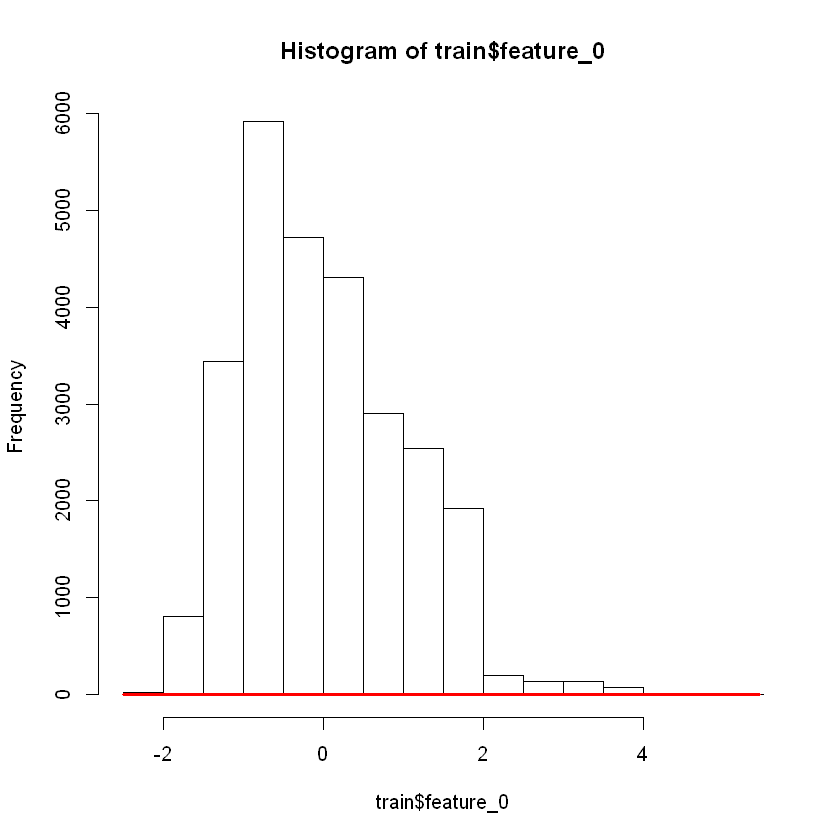

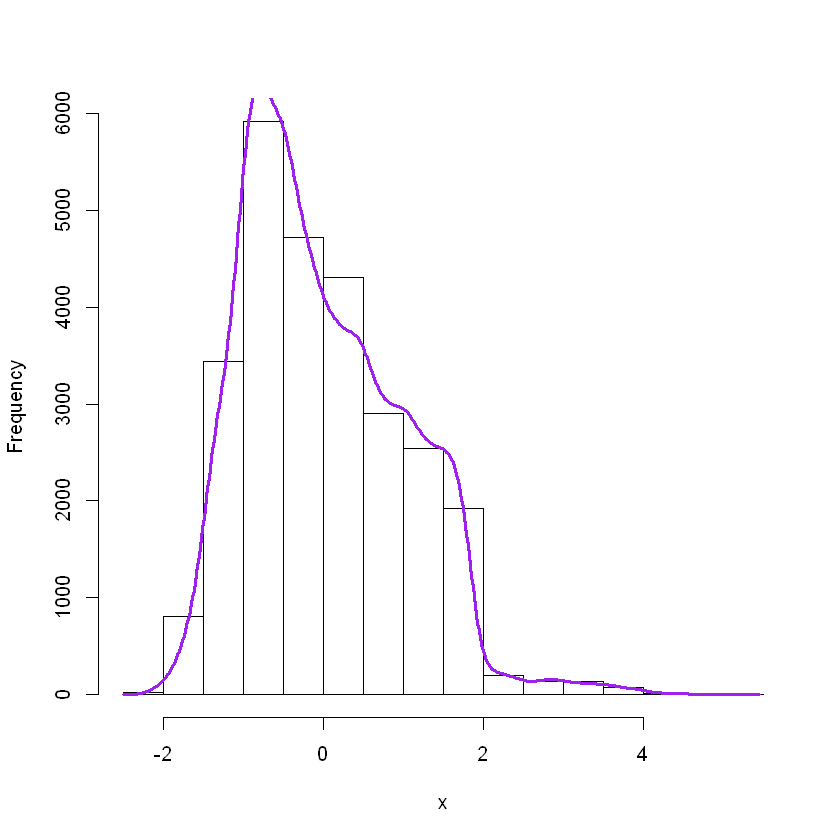

In [21]:
## Make some sample data
x <- train$feature_0

## Calculate and plot the two histograms
h <- hist(x, plot=FALSE)
plot(h, main="")


## Plot the density and cumulative density
d <- density(x)
lines(x = d$x, y = d$y * length(x) * diff(h$breaks)[1], col = "purple", lwd = 3)

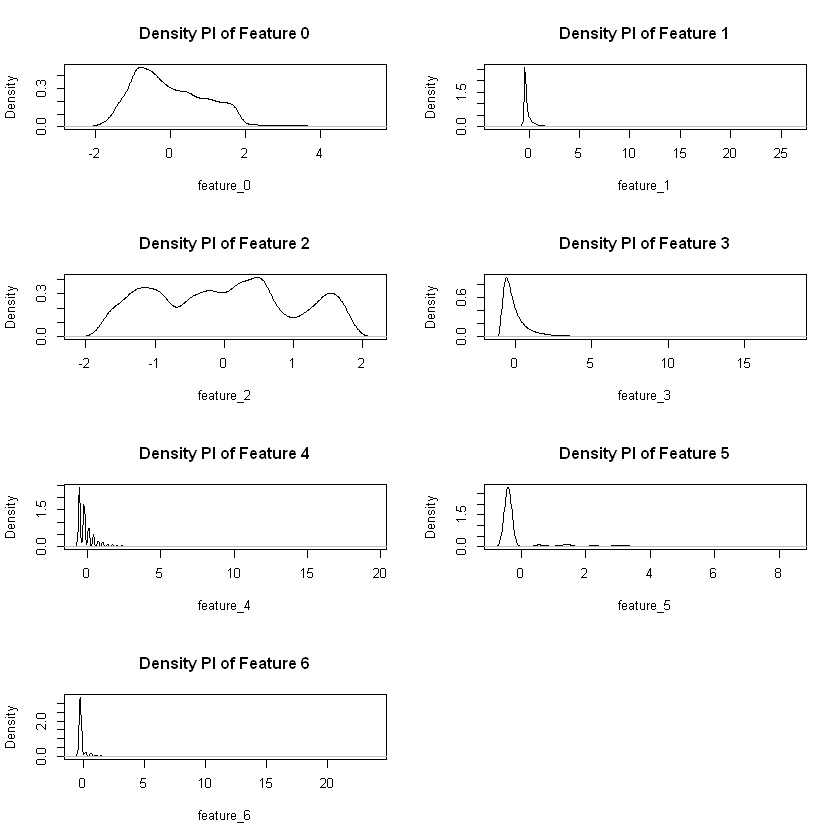

In [22]:
# Histogram for features 0 to 6
par(mfrow = c(4,2))
for (i in 1:7 ) {
        plot(density(train[,i]), xlab = names(train[i]), main = paste("Density Pl of Feature", i-1))
}

A mix of left skewed (0), exponential (1, 3, 4 & 6) and uniformly (2?) distributed features are seen here. 

Feature 5 is unusual looking, it might be better seen/understood on a logarithmic scale:

In [ ]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=2) 
#par(mfrow = c(1,2))

barplot(table(train[,6]), log="y", xlab = names(train[,6]), main = paste("Log scaled Feature", 5))

This is definately not the best chart option for the job, but it does have an inbuilt log scale. 

It could be improved with binning:

In [ ]:
barplot(table(bin(train[,6], nbins = 20)), log = "y", xlab = "feature_5", ylab = "log(Frequency)", main = "Barplot of Feature 5 with Log y Scale and binned x data")

What to say about this?

In trying to acheive the above, we also stumbled across another interesting result by taking the log of feature 5 (as opposed to adding a log scale to the frequency axis)

In [ ]:
hist(log(train[,6]), xlab = names(train[6]), main = paste("Histogram of Log( Feature", 5, ")"))

Well, that's a lot more revealing that I had anticipated...

We now have a variable that is right skewed normal distribution after logarithmic transformation of the data.

Bar chart exploration for our discrete data:

In [ ]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=1) 

# Bar chart for features 7 to 15
par(mfrow = c(5,2))
for (i in 8:16 ) {
        barplot(table(train[,i]), xlab = names(train[i]), main = paste("Bar plot of Feature", i-1))
}


Exploration so far tells us:

### Quantitative vs Qualitative Variables:
As we suspected from the summary statistics, we can see that features 0 - 6 are continuous while 7 to 15 are discrete. As we have no context for this data, we cannot deduce easily whether the discrete variables are ordinal (logically ordered or ranked) or nominal (have no logical sequence). It is possible that their relationships with other variables could reveal the possibility of a rank or logical order, but we can never know for certain. This information is important to determine whether one hot encoding is needed for specific learning algorithms.

### Distributions:
Other notable observations incluide that feature 0 is skewed to the left while  it appears that 1, 3, 4 & 6 are all exponential (although increasing the bins might yet reveal they are all very highly skewed instead). Feature 5 looks interesting, it could be skewed, exponential or something else entirely. Meanwhile feature 2 is fairly uniformly distributed (possibly 7 and 11 too). Many of the integer features (7 and above) show a clear imbalance where one class is prefenced (particularly 10, 12 and 15). Features 8 and 9 could be somewhat normally distributed (the discretness of this data does not clearly show skew, there are too few possible values). It's hard to determine what information 7 & 14 have to give from this, they are discrete with no clear distribution meaning that they could be nominal variables with no clear rank or order, these would be prime candidates for tree methods or one hot encoding for other learning methods.

### Labels class imbalance
The response variable is not evenly distributed. The majority class (0) is very dominant here and so we expect that learning algorithms will significantly favour this class for positive prediction. Resampling may be necessary so as not to introduce bias in our learning/modelling algorithms.

### Feature scaling
Feature scaling has not been completed on this dataset. Some algorithms might need us to preform this.

### Other notes
No missing data in any features. Given that we don't have any particular knowledge about each feature, we cannot comment more generally on the expected or unexpected characteristics of each variable, such as the range of values and outliers.
_________________________

Box plots of numeric and integer vars seperated for easier readability.

Continuous variables:

In [ ]:
boxplot(train[1:7], las=2, cex.axis = 1)

Discrete variables:

In [ ]:
boxplot(train[8:17], las=2, cex.axis = 1)

Earlier we found features 10,11 and 12 along with the labels all have two possible discrete values. It appears all but feature 11 are primarliy distributed at zero with less than a quarter of the data at one. Feature 11 on the otherhand is a little more evenly distributed with one quartile of the data distributed at zero and the remainder at one.

In [ ]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=1) 

The correlation between each feature and the labels.

In [ ]:
par(mfrow = c(4,4))
for (i in 1:(length(train) - 1)) {
        plot(train[,i], train$labels, ylab = 'labels', xlab = names(train)[i])
}

There appear to be differences in the distribution of data for each label correlated with features 1, 4 and 6. It is questionable whether this is also the case for 1, 3 and 5. These features should be explored further using geom_density filled by label to distinguish...

Correlation of all features and labels:

In [ ]:
round(cor(train),3)

Correlation measurements are for the most part relatively low, the top 5 include:
1. -0.855 between features 5 & 15
2. -0.596	between features 15 & 6
3. 0.547	between features  5 & 6
4. -0.405	between features 8 and 0
5. 0.390	between the labels and 3

Remember this only measures the linear relationship between two variables. Visualising with all with a scatter plot could bring other non linear relationship patterns to the surface. These are a bit crowded with so many features though, so we will focus on the top 5 we've highlighted for now.

In [ ]:
par(mfrow = c(2,3))
plot(train$feature_0, train$feature_8, main = "Features 0 & 8", sub = "Cor = -0.405")
plot(train$feature_3, train$labels, main = "Feature 0 & labels", sub = "Cor = -0.390")
plot(train$feature_5, train$feature_6, main = "Features 5 & 6", sub = "Cor = 0.547")
plot(train$feature_5, train$feature_15, main = "Features 5 & 15", sub = "Cor = -0.855")
plot(train$feature_6, train$feature_15, main = "Features 6 & 15", sub = "Cor = -0.596")

We can't really comment on whether we expected these correlations, we just know they're the most significant linear relationships we have found.

Analysing labels seperately to find differences:

In [ ]:
colorRange <- c('#69091e', '#e37f65', 'white', '#aed2e6', '#042f60')
## colorRamp() returns a function which takes as an argument a number
## on [0,1] and returns a color in the gradient in colorRange
myColorRampFunc <- colorRamp(colorRange)

panel.cor <- function(w, z, ...) {
    correlation <- cor(w, z)

    ## because the func needs [0,1] and cor gives [-1,1], we need to shift and scale it
    col <- rgb(myColorRampFunc((1 + correlation) / 2 ) / 255 )

    ## square it to avoid visual bias due to "area vs diameter"
    radius <- sqrt(abs(correlation))
    radians <- seq(0, 2*pi, len = 50) # 50 is arbitrary
    x <- radius * cos(radians)
    y <- radius * sin(radians)
    ## make them full loops
    x <- c(x, tail(x,n=1))
    y <- c(y, tail(y,n=1))

    ## trick: "don't create a new plot" thing by following the
    ## advice here: http://www.r-bloggers.com/multiple-y-axis-in-a-r-plot/
    ## This allows
    par(new=TRUE)
    plot(0, type='n', xlim=c(-1,1), ylim=c(-1,1), axes=FALSE, asp=1)
    polygon(x, y, border=col, col=col)
}

In [ ]:
#increase scale size of jupyter plots for some very detailed ones momentarily.
options(jupyter.plot_scale=1.5) 

In [ ]:
pairs(train[train$labels==1,-17], upper.panel = panel.cor, main = "Label = 1")

In [ ]:
pairs(train[train$labels==0,-17], upper.panel = panel.cor, main = "Label = 0")

There appears to be no major differences in correlation between any features and the two label values. This indicates that regression may not perform well with this data.

In [ ]:
# just a prototype to hopefully overlay two density plots depending on the label.
plot(density(train[train$labels == 1,6]))
plot(density(train[train$labels == 0,6]))

Explore distribution of variables for each seperate label side by side.

In [ ]:
# What to do with this information??
ggplot(aes(x=feature_6),data =train) + 
    geom_density(aes(fill = labels)) +
    facet_wrap(~feature_11) +
    ggtitle('title')

ggplot(aes(x=feature_5),data =train) + 
    geom_density(aes(fill = labels)) +
    facet_wrap(~feature_8) +
    ggtitle('title')

In [ ]:
ggplot(aes(x = feature_6),data = train) + 
    geom_density(aes(fill = labels)) +
    facet_wrap(~feature_13) +
    ggtitle('pH values  relationship with Quality')

### Model selection and justification
Clearly explained how the models were developed with sufficient supporting information derived from exploratory data analysis and proper statistical diagnostics.

The exploratory analysis and diagnostics logically lead to the development of the models (including attribute/feature selection).

# Modelling

### Model quality comparison
Critically assess the accuracy of the models with in-depth statistical analysis. 

The comparison is logical and solid with an appropriate level of details. 

Demonstrates a high-level of understanding of the differences (i.e., advantages and disadvantages) between the models in regard to the task.

# Summary
Explanation of why the chosen subset of attributes have a significant impact on the prediction of the response variable.
- The subset of attributes leading to the prediction are identified and clearly justified with in-depth statistical analysis.
- The description and accompanying interpretation are comprehensible and convincing, in line with the findings from the model development.

The quality of the Jupiter notebook/ the R Markdown file, quality and readability of the R implementation.
- The Jupyter  Notebook is well structured in a logical order that clearly supports the development of the answers.
- The R code is logically structured and easy to read.
- Concise but precise code comments clearly explain how the code is intended to work.
- The redundant or unnecessary code is excluded from the final submission.


# Questions:
- Should test and train be merged during EDA - so we get the fullest picture of the data?
- The Week 2 tutorial explores the relationship between many variables with one another. Are we interested in just the relationships that we wish to predict? Why would we explore other relationships aside from just looking for duplicated information?


# Concerns to follow up before modelling
- Resample data to even out label class
- Are categoric data ordinal? Should they be one hot encoded? Specifically look at 7, 8, 9, 13, 14, 15.
- Feature scaling might be needed for some models
- 